# [地図タイル画像を比較する](https://www.tellusxdp.com/ja/howtouse/20200221_000259.html)

## Jupyter Notebook 上で衛星データと抜き出す領域の GeoJSON を取得する

In [1]:
import json
import math
import os

import numpy as np
import requests
from io import BytesIO
from skimage import io
from skimage.draw import polygon

%matplotlib inline

fpth_secret = os.path.join(os.environ['HOME'], 'working/jupyter/secret.json')
with open(fpth_secret) as f:
    secret = json.load(f)
TOKEN = secret['tellus']
HEADERS = {
    'Authorization': 'Bearer ' + TOKEN
}

In [2]:
def fetch_avnir2_sceneid(productid):
    url = f'https://gisapi.tellusxdp.com/api/v1/av2ori/get_scene/{productid}'
    
    r = requests.get(url, headers=HEADERS)
    
    if r.status_code == 200:
        return r.json()
    elif r.status_code == 404:
        return None
    elif r.status_code == 412:
        print('Precondition Failed')
        return None

In [3]:
def fetch_avnir2_image(sceneid, tile, color):
    url = 'https://gisapi.tellusxdp.com/' + sceneid['tile_path'].format(**tile)
    
    r = requests.get(url, params=color, headers=HEADERS)
    
    if r.status_code == 200:
        return io.imread(BytesIO(r.content))
    elif r.status_code == 404:
        print('Not Found')
        return None
    elif r.status_code == 412:
        print('Precondition Failed')
        return None

In [4]:
def fetch_avnir2_image_by_productid(productid, tile, color):
    sceneid = fetch_avnir2_sceneid(productid)
    img = fetch_avnir2_image(sceneid, tile, color)
    return img

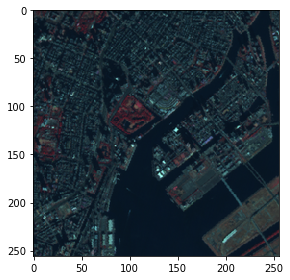

In [5]:
productid1 = 'ALAV2A266502880'

tile1 = {
    'x': 7276,
    'y': 3226,
    'z': 13
}

color1 = {
    'preset': 'false',
    'opacity': 1,
    'r': 3,
    'g': 2,
    'b': 1,
    'rdepth': 1,
    'gdepth': 1,
    'bdepth': 1
}

img1 = fetch_avnir2_image_by_productid(
    productid1,
    tile1,
    color1
)
io.imshow(img1)

In [6]:
def fetch_geojson_by_name(name):
    url = 'https://api.tellusxdp.com/v2/geojson-files/'
    
    # 全てのポリゴンを取得
    r = requests.get(url, headers=HEADERS)
    polygons = r.json()
    
    # 名前を検索
    for polygon in polygons['results']:
        if polygon['original_name'] == name:
            r = requests.get(polygon['url'])
            return r.json()

In [7]:
polygon_json1 = fetch_geojson_by_name('polygon-1')
# print(json.dumps(polygon_json_1, indent=2))

In [8]:
def num2deg(xtile, ytile, zoom):
    # https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Python
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
    lat_deg = math.degrees(lat_rad)
    return (lon_deg, lat_deg)
    
def calc_tile_bbox(tile):
    """
    タイル座標からバウンディングボックスを取得
    https://tools.ietf.org/html/rfc7946#section-5
    """
    right_top = num2deg(tile['x'] + 1, tile['y'], tile['z'])
    left_bottom = num2deg(tile['x'], tile['y'] + 1, tile['z'])
    return (left_bottom[0], left_bottom[1], right_top[0], right_top[1])
    
def world2pixel(bbox, size, lon, lat):
    """
    世界座標 (緯度経度) を画像座標 (ピクセル) に変換
    """
    dist = (
        (bbox[2] - bbox[0]) / size[0],
        (bbox[3] - bbox[1]) / size[1]
    )
    pixel = (
        int((lon - bbox[0]) / dist[0]),
        int((bbox[3] - lat) / dist[1])
    )
    return pixel

def get_polygon_image(points, bbox, dct_img_size):
    pixels = []
    img_size = (dct_img_size['width'], dct_img_size['height'])
    for p in points:
        pixels.append(world2pixel(bbox, img_size, p[0], p[1]))
    pixels = np.array(pixels)
    poly = np.ones(img_size, dtype=np.uint8)
    rr, cc = polygon(pixels[:, 1], pixels[:, 0], poly.shape)
    poly[rr, cc] = 0
    return poly

In [9]:
points = polygon_json1['geometry']['coordinates'][0]
bbox = calc_tile_bbox(tile1)
px_size = {'height': img1.shape[0], 'width': img1.shape[1]}
mask = get_polygon_image(points, bbox, px_size)

/home/ubuntu/working/venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


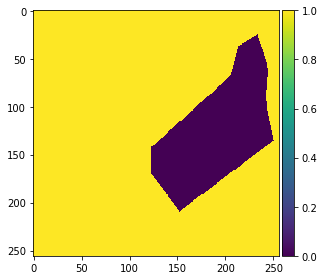

In [10]:
io.imshow(mask)

In [11]:
def clip_image(img, mask):
    base = img.transpose(2, 0, 1)[:3, :]
    clipped = np.choose(mask, (base, 0)).astype(np.uint8)
    return clipped.transpose(1, 2, 0)

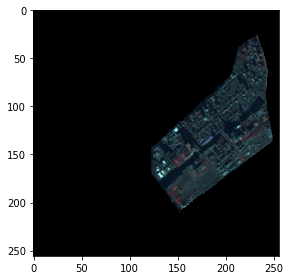

In [12]:
clipped_img1 = clip_image(img1, mask)
io.imshow(clipped_img1)

## 2 地点比較

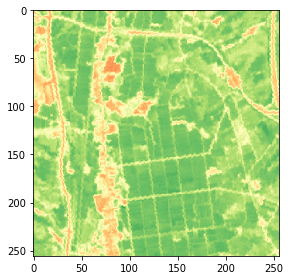

In [13]:
productid2 = 'ALAV2A134782770'
tile2 = {'x': 14590, 'y': 6158, 'z': 14}
color2 = {'preset': 'ndvi'}
img2 = fetch_avnir2_image_by_productid(productid2, tile2, color2)
io.imshow(img2)

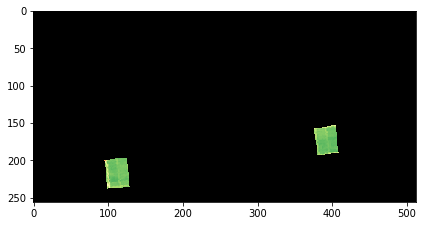

In [14]:
bbox = calc_tile_bbox(tile2)
px_size = {'height': img2.shape[0], 'width': img2.shape[1]}

polygon_json = fetch_geojson_by_name('polygon-2')
points = polygon_json['geometry']['coordinates'][0]
mask = get_polygon_image(points, bbox, px_size)
clipped_img2_1 = clip_image(img2, mask)

polygon_json = fetch_geojson_by_name('polygon-3')
points = polygon_json['geometry']['coordinates'][0]
mask = get_polygon_image(points, bbox, px_size)
clipped_img2_2 = clip_image(img2, mask)

io.imshow(np.hstack((clipped_img2_1, clipped_img2_2)))

In [15]:
from PIL import Image

def filter_green(img_rgb):
    min_hsv = np.array([80, 0, 0])
    max_hsv = np.array([100, 255, 255])
    
    pil_img_rgb = Image.fromarray(img_rgb)
    pil_img_hsv = pil_img_rgb.convert("HSV") # h: 0 ~ 255
    np_img_hsv = np.array(pil_img_hsv)
    h, s, v = np.squeeze(np.dsplit(np_img_hsv, 3))
    
    mask = np.zeros(h.shape, dtype = np.uint8)
    mask[
        (min_hsv[0] < h) & (h < max_hsv[0]) &
        (min_hsv[1] < s) & (s < max_hsv[1]) &
        (min_hsv[2] < v) & (v < max_hsv[2])
    ] = 1
    mask = np.repeat(mask[:, :, None], 3, axis=2) # (h, w) -> (h, w, c)
    
    masked_img = img_rgb * mask
    return masked_img

Area1: 20.017035775127766
Area2: 41.46806482364156


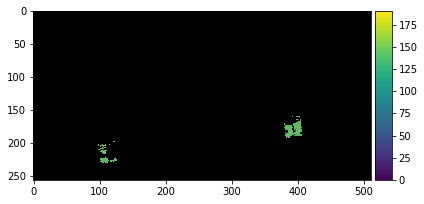

In [16]:
filtered_img2_1 = filter_green(clipped_img2_1)
filtered_img2_2 = filter_green(clipped_img2_2)
io.imshow(np.hstack((filtered_img2_1, filtered_img2_2)))

area1 = len(np.nonzero(filtered_img2_1.flatten())[0]) / len(np.nonzero(clipped_img2_1.flatten())[0])  * 100
area2 = len(np.nonzero(filtered_img2_2.flatten())[0]) / len(np.nonzero(clipped_img2_2.flatten())[0])  * 100
print(f"Area1: {area1}")
print(f"Area2: {area2}")

## 時間での変化を捉える

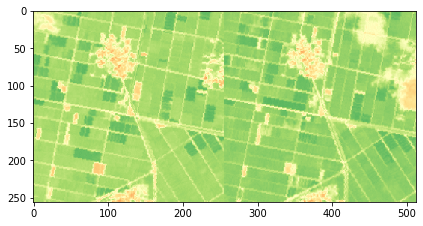

In [17]:
tile3 = {
    'x': 14578,
    'y': 6154,
    'z': 14
}
color3 = {'preset': 'ndvi'}

productid3_1 = 'ALAV2A083582770'
productid3_2 = 'ALAV2A137262780'
img3_1 = fetch_avnir2_image_by_productid(productid3_1, tile3, color3)
img3_2 = fetch_avnir2_image_by_productid(productid3_2, tile3, color3)
io.imshow(np.hstack((img3_1, img3_2)))

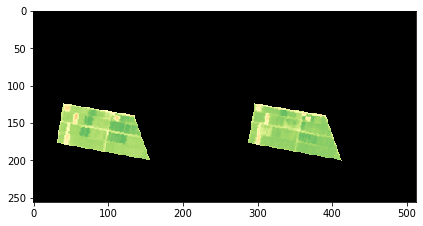

In [18]:
bbox = calc_tile_bbox(tile3)
px_size  = {'height': img3_1.shape[0], 'width': img3_1.shape[1]}
polygon_json = fetch_geojson_by_name('polygon-4')
points = polygon_json['geometry']['coordinates'][0]
mask = get_polygon_image(points, bbox, px_size)

clipped_img3_1 = clip_image(img3_1, mask)
clipped_img3_2 = clip_image(img3_2, mask)
io.imshow(np.hstack((clipped_img3_1, clipped_img3_2)))

Area1: 5.932481153720092
Area2: 1.3274336283185841


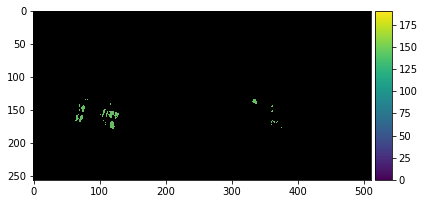

In [19]:
filtered_img3_1 = filter_green(clipped_img3_1)
filtered_img3_2 = filter_green(clipped_img3_2)
io.imshow(np.hstack((filtered_img3_1, filtered_img3_2)))

area1 = len(np.nonzero(filtered_img3_1.flatten())[0]) / len(np.nonzero(clipped_img3_1.flatten())[0])  * 100
area2 = len(np.nonzero(filtered_img3_2.flatten())[0]) / len(np.nonzero(clipped_img3_2.flatten())[0])  * 100
print(f"Area1: {area1}")
print(f"Area2: {area2}")